In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.filt import filter_signal
from neurodsp.utils.norm import normalize_sig
from neurodsp.plts import plot_time_series
from neurodsp.spectral import compute_spectrum

from fooof import FOOOF

from ndspflow.motif import Motif
from emd.sift import it_emd_sift

from timescales.fit import fit_psd

## Overview

### 1. itEMD + Motif Extraction

This notebook uses itEMD to decompose a signal into pre-peak/peak/post-peak components. Motifs of these components show that similar waveform shapes (motifs) are across low and high frequencies.

Two interpretations could explain this:

1. Dynamic processes that flucates in frequency over time.
2. Static processes that exists in distinct frequencies but produces similar waveform shapes.


### 2. itEMD + Timescales

A second analysis examines how knee frequencies vary per mode. For this section to run, the timescales repository must be installed.

In [2]:
# Normalize and filter the data
sig_lfp = np.load('../data/ca1.npy')
fs = 1250

sig_lfp = normalize_sig(sig_lfp, mean=0, variance=1)
sig_lfp = filter_signal(sig_lfp, fs, 'lowpass', 200, remove_edges=False)

times = np.arange(0, len(sig_lfp)/fs, 1/fs)

## 1. itEMD + Motif Extraction

Iterative EMD is applied to the low-pass filtered signal below.

IMF 2 contains a very clean / isolated theta rhythm.

In [3]:
# EMD sifting
imfs = it_emd_sift(sig_lfp, fs, max_imfs=5, iter_th=.1, w_method='IA', max_iter=100).T[::-1]

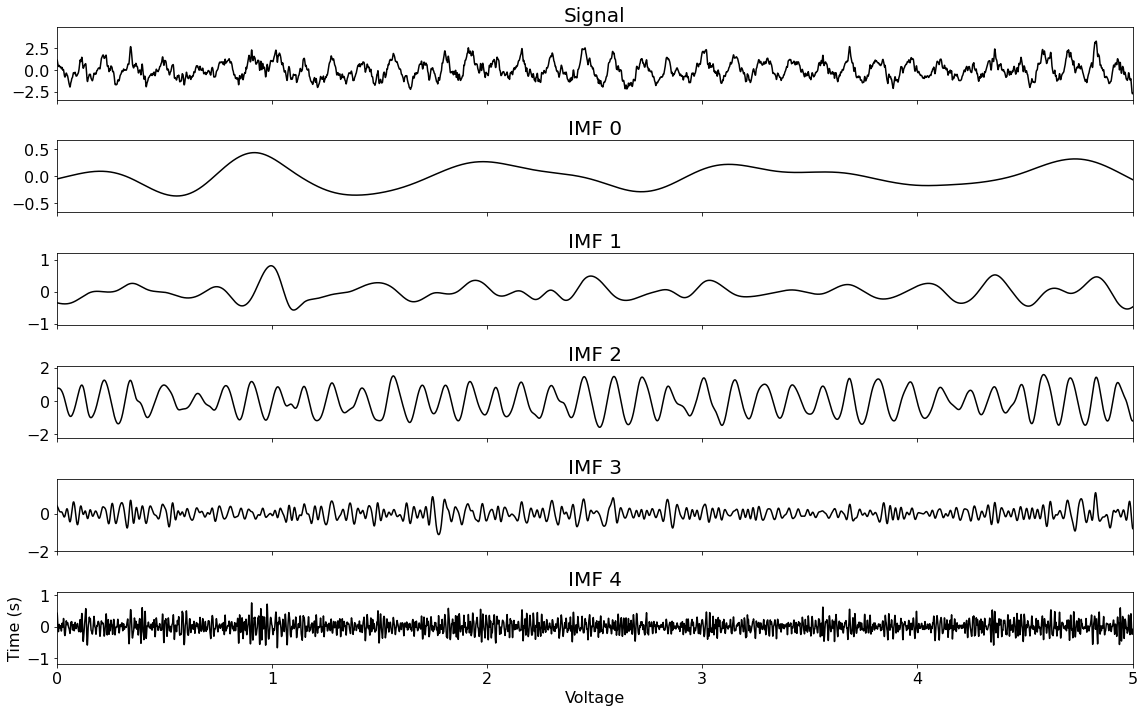

In [4]:
# Plot EMD
fig, axes = plt.subplots(nrows=6, figsize=(16, 10), sharex=True)

plot_time_series(times, sig_lfp, xlim=(0, 5), ax=axes[0], xlabel='', ylabel='', title='Signal')

for ind, (imf, ax) in enumerate(zip(imfs, axes[1:])):
    title = 'IMF ' + str(ind)
    if ind == len(axes)-2:
        plot_time_series(times, imf, xlim=(0, 5), ax=ax, xlabel='Voltage', ylabel='Time (s)',
                         title=title)
    else:
        plot_time_series(times, imf, xlim=(0, 5), ax=ax, xlabel='', ylabel='', title=title)

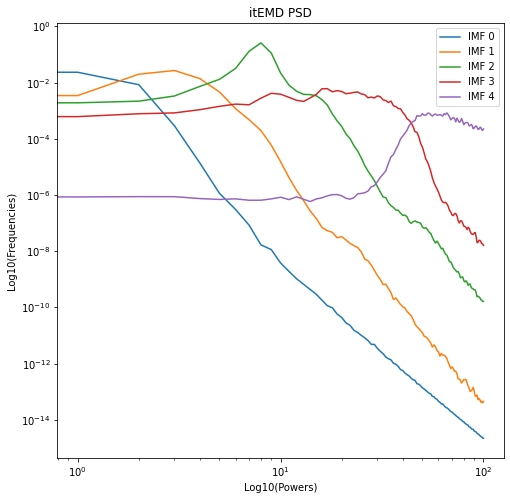

In [5]:
# EMD to spectral decomposition
freqs_emd, powers_emd = compute_spectrum(imfs, fs, f_range=(0, 100))

plt.figure(figsize=(8, 8))
for ind, p in enumerate(powers_emd):
    label = title = 'IMF ' + str(ind)
    
    plt.loglog(freqs_emd, p, label=label)
    
plt.title('itEMD PSD')
plt.ylabel('Log10(Frequencies)')
plt.xlabel('Log10(Powers)')
plt.legend();

### Combining Modes
Next we combine the modes into three sets:

1. Pre-Peak Modes (low frequencies)
2. Oscillitory Modes
3. Post-peak Modes (high frequencies)

In [6]:
low_imfs = imfs[:2].sum(axis=0)
osc_imfs = imfs[2]
hi_imfs = imfs[3:].sum(axis=0)


freqs, powers = compute_spectrum(sig_lfp, fs, f_range=(0, 200))
f_lo, p_lo = compute_spectrum(low_imfs, fs, f_range=(0, 200))
f_osc, p_osc = compute_spectrum(osc_imfs, fs, f_range=(0, 200))
f_hi, p_hi = compute_spectrum(hi_imfs, fs, f_range=(0, 200))

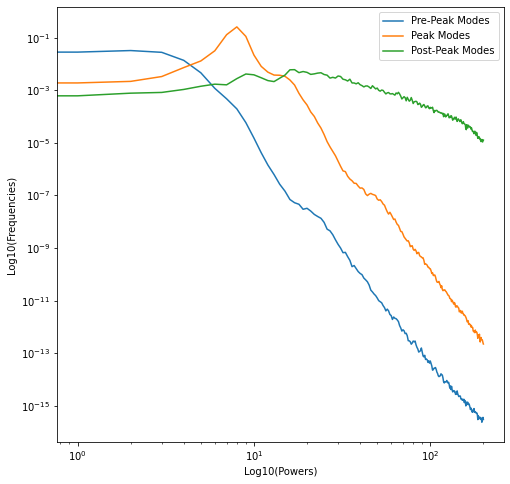

In [7]:
plt.figure(figsize=(8, 8))

#plt.loglog(freqs, powers, label='Orig')
plt.loglog(f_lo, p_lo, label='Pre-Peak Modes')
plt.loglog(f_osc, p_osc, label='Peak Modes')
plt.loglog(f_hi, p_hi, label='Post-Peak Modes')

plt.ylabel('Log10(Frequencies)')
plt.xlabel('Log10(Powers)')
plt.legend();

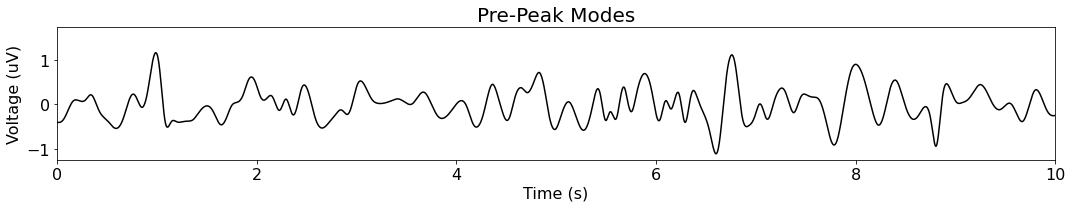

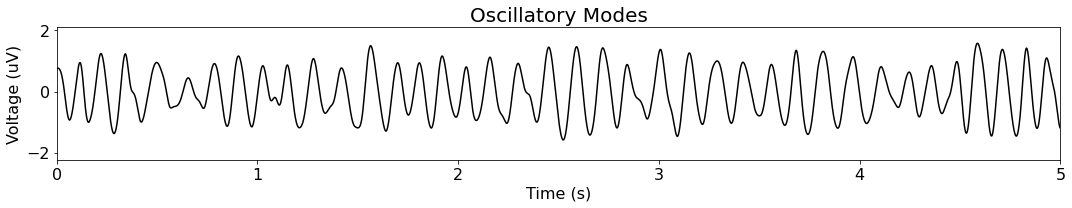

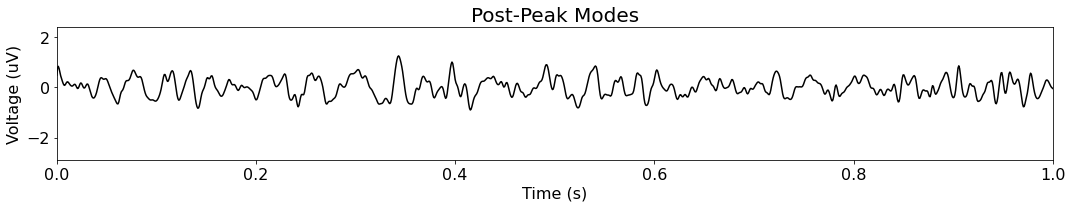

In [8]:
# Note: the scale of the x-axis changes but similar waveform shapes are found
plot_time_series(times, low_imfs, xlim=(0, 10), title='Pre-Peak Modes')
plot_time_series(times, osc_imfs, xlim=(0, 5), title='Oscillatory Modes')
plot_time_series(times, hi_imfs, xlim=(0, 1), title='Post-Peak Modes')

### Results

Notice how the pre and post peak motifs below look very similar, but exist at different timescales (120 samples vs 12000 samples).

In [9]:
fm = FOOOF(aperiodic_mode='knee', verbose=False, peak_threshold=3)
fm.fit(freqs, powers)
cf, bw = fm.get_params('peak')[0][[0, 2]]

motif_lo = Motif(corr_thresh=.1, max_clusters=3,  min_clust_score=0, var_thresh=0)
motif_lo.fit([(0.1, cf-2*bw)], low_imfs, fs, ttype='affine')

motif_osc = Motif(corr_thresh=.1, max_clusters=3,  min_clust_score=0, var_thresh=0)
motif_osc.fit([(cf-2*bw, cf+2*bw)], osc_imfs, fs, ttype='affine')

motif_hi = Motif(corr_thresh=.1, max_clusters=3,  min_clust_score=0, var_thresh=0)
motif_hi.fit([(cf+2*bw, 100)], hi_imfs, fs, ttype='affine')

Text(0.5, 0, 'Samples')

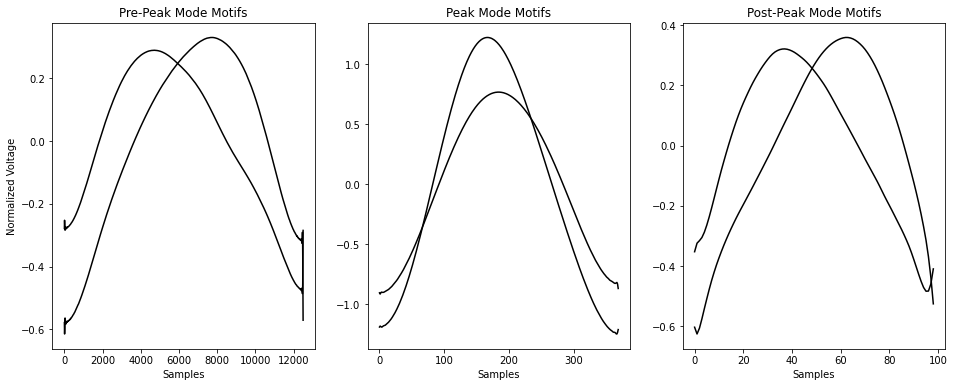

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 6))

for i in motif_lo[0].motif:
    axes[0].plot(i, color='k')
    
for i in motif_osc[0].motif:
    axes[1].plot(i, color='k')
    
for i in motif_hi[0].motif:
    axes[2].plot(i, color='k')
    
axes[0].set_title('Pre-Peak Mode Motifs')
axes[1].set_title('Peak Mode Motifs')
axes[2].set_title('Post-Peak Mode Motifs')

axes[0].set_ylabel('Normalized Voltage')
axes[0].set_xlabel('Samples')
axes[1].set_xlabel('Samples')
axes[2].set_xlabel('Samples')

## 2. itEMD + Timescales

All modes, with the exception of the last/high frequency mode, all have distinct knees. Here we measure the knee of each mode and compare to the original signal

In [11]:
# EMD to spectral decomposition
#freqs_emd, powers_emd = compute_spectrum(imfs, fs, f_range=(0, 200))

powers_knees = powers_emd[:-1]



In [12]:
knee_bounds=(.1, 200)

fooof_init = dict(max_n_peaks=2, peak_threshold=3, peak_width_limits=(2, 10))


In [13]:
fm_emd, knee_freqs_emd, taus_emd = fit_psd(freqs_emd, powers_knees, (0, 100),
                                           fooof_init=fooof_init, knee_bounds=knee_bounds)


fm, knee_freq, tau= fit_psd(freqs, powers, (0, 100),
                            fooof_init=fooof_init, knee_bounds=knee_bounds)

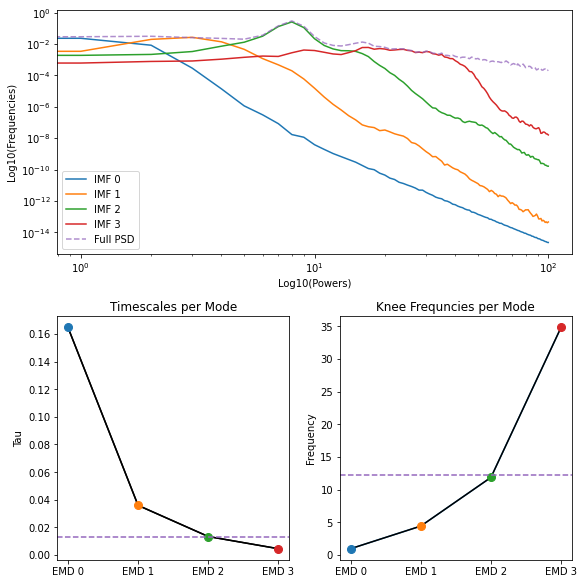

In [14]:
fig = plt.figure(constrained_layout=True, figsize=(8, 8))

gs = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])


for ind, p in enumerate(powers_knees):
    label = 'IMF ' + str(ind)
    ax0.loglog(freqs_emd, p, label=label)
    
_freqs = freqs[np.where(freqs <= 100)]
_powers = powers[np.where(freqs <= 100)]
ax0.loglog(_freqs, _powers, color='C4', alpha=.75, label='Full PSD', ls='--')


ax0.set_ylabel('Log10(Frequencies)')
ax0.set_xlabel('Log10(Powers)')
ax0.legend()

# Timescales
ax1.plot(np.arange(len(fm_emd)), taus_emd, color='k')

colors = ['C' + str(i) for i in range(len(fm_emd))]

ax1.plot(np.arange(len(fm_emd)), taus_emd, color='k')

for ind, (kf, color) in enumerate(zip(taus_emd, colors)):
    ax1.plot(ind, kf, color=color, marker='.', ms=16)
    
ax1.axhline(tau, ls='--', color='C4')
ax1.set_ylabel('Tau')
ax1.set_xticks(np.arange(len(fm_emd)))
ax1.set_xticklabels(['EMD ' + str(i) for i in range(len(fm_emd))])
ax1.set_title('Timescales per Mode')

# Knee Freqs 
ax2.plot(np.arange(len(fm_emd)), knee_freqs_emd)

colors = ['C' + str(i) for i in range(len(fm_emd))]

ax2.plot(np.arange(len(fm_emd)), knee_freqs_emd, color='k')

for ind, (kf, color) in enumerate(zip(knee_freqs_emd, colors)):
    ax2.plot(ind, kf, color=color, marker='.', ms=16)

ax2.axhline(knee_freq, ls='--', color='C4')
ax2.set_ylabel('Frequency')
ax2.set_xticks(np.arange(len(fm_emd)))
ax2.set_xticklabels(['EMD ' + str(i) for i in range(len(fm_emd))])
ax2.set_title('Knee Frequncies per Mode');